In [101]:
from pprint import pprint

import pandas as pd
import numpy as np

In [2]:
als_recommendations = pd.read_parquet('data/als_recommendations.parquet')
als_transactions_train = pd.read_parquet('data/als_transactions_train.parquet')
als_transactions_test = pd.read_parquet('data/als_transactions_test.parquet')

In [72]:
als_transactions_train

,element_uid,user_uid,consumption_mode,ts,watched_time,device_type,device_manufacturer,rank_per_user
0,8546,408484,S,4.430477e+07,0,5,90,3
1,9817,428798,S,4.430474e+07,4302,5,90,3
2,627,408484,S,4.430472e+07,0,5,90,4
3,3017,408484,S,4.430453e+07,777,0,90,5
4,6272,193139,S,4.430448e+07,7,0,50,3
...,...,...,...,...,...,...,...,...
6565605,2252,180823,S,4.173063e+07,2503,0,11,18
6565606,8436,458827,S,4.173063e+07,8360,0,50,17
6565607,8888,50431,S,4.173063e+07,5763,0,11,28
6565608,6099,59148,S,4.173063e+07,6831,0,50,85


### Label ALS recommendations

In [7]:
als_recommendations_labeled = (
    als_recommendations
    .merge(
        (
            als_transactions_test[['user_uid', 'element_uid']]
            .assign(label=1)
        ),
        on=['user_uid', 'element_uid'],
        how='left',
    )
)

als_recommendations_labeled['label'] = (
    als_recommendations_labeled['label']
    .fillna(0)
    .astype('int32')
)

In [16]:
positive_classes_rate = als_recommendations_labeled['label'].sum() / len(als_recommendations_labeled)
print(f'Positive classes = {positive_classes_rate * 100:.2f}%')

Positive classes = 0.43%


## Generate features for boosting

### Add item popularity

In [44]:
item_features = (
    als_transactions_train
    .groupby('element_uid')
    .size()
    .reset_index(name='element_occurences')
)

item_features['element_popularity'] = (
    item_features['element_occurences'] / 
    als_transactions_train['element_uid'].nunique()
)

item_features.drop(columns=['element_occurences'], inplace=True)

### Add item bookmark count

In [55]:
bookmarks = pd.read_csv('data/hse/train_bookmarks.csv')

In [60]:
bookmarks_per_item = (
    bookmarks
    .groupby('element_uid')
    .size()
    .reset_index(name='element_bookmark_count')
)

In [64]:
bookmarks_per_item

,element_uid,element_bookmark_count
0,1,11
1,2,1
2,3,56
3,5,15
4,6,13
...,...,...
9328,10195,10
9329,10196,13
9330,10197,3
9331,10198,6


In [62]:
item_features = (
    item_features
    .merge(
        bookmarks_per_item,
        on='element_uid',
        how='left'
    )
)

item_features['element_bookmark_count'].fillna(0, inplace=True)

In [71]:
item_features

,element_uid,element_popularity,element_bookmark_count
0,0,0.000606,0.0
1,1,0.000849,11.0
2,3,0.259304,56.0
3,5,0.005940,15.0
4,7,0.030307,40.0
...,...,...,...
8244,10195,0.003031,10.0
8245,10196,0.024003,13.0
8246,10197,0.006061,3.0
8247,10198,0.007516,6.0


### Add user watch count

In [67]:
user_features = (
    als_transactions_train
    .groupby('user_uid')
    .size()
    .reset_index(name='user_watch_count')
)

In [70]:
user_features

,user_uid,user_watch_count
0,0,90
1,1,13
2,3,44
3,7,16
4,8,7
...,...,...
254844,593477,6
254845,593478,5
254846,593482,100
254847,593486,20


### Add user watch time std

In [77]:
user_watch_time_std = (
    als_transactions_train
    .groupby('user_uid')['watched_time']
    .std()
    .reset_index(name='user_watch_time_std')
)

user_features = (
    user_features
    .merge(
        user_watch_time_std,
        on='user_uid',
        how='left'
    )
)

In [78]:
user_features

,user_uid,user_watch_count,user_watch_time_std
0,0,90,3374.149391
1,1,13,1917.229876
2,3,44,13953.814998
3,7,16,2586.838121
4,8,7,2418.781236
...,...,...,...
254844,593477,6,3110.908961
254845,593478,5,14356.422127
254846,593482,100,5385.300187
254847,593486,20,4604.584613


### Merge features to dataset for boosting training

In [79]:
gbt_features = (
    als_recommendations_labeled
    .merge(
        item_features,
        on='element_uid',
        how='left'
    )
    .merge(
        user_features,
        on='user_uid',
        how='left'
    )
)

In [80]:
gbt_features

,score,user_uid,element_uid,label,element_popularity,element_bookmark_count,user_watch_count,user_watch_time_std
0,0.763442,0,5893,0,0.505395,139.0,90,3374.149391
1,0.749019,0,9886,0,0.690993,252.0,90,3374.149391
2,0.715760,0,9491,0,1.809916,1764.0,90,3374.149391
3,0.676208,0,3270,0,0.417020,355.0,90,3374.149391
4,0.675924,0,1636,0,1.744818,247.0,90,3374.149391
...,...,...,...,...,...,...,...,...
50969795,0.168714,593489,5332,0,0.250576,54.0,23,2839.492408
50969796,0.168454,593489,4382,0,0.101952,119.0,23,2839.492408
50969797,0.168252,593489,8630,0,0.101831,42.0,23,2839.492408
50969798,0.168207,593489,5702,0,0.087647,41.0,23,2839.492408


### Split to train/test GBT features

In [97]:
from sklearn.model_selection import train_test_split

gbt_features_train, gbt_features_test = train_test_split(
    gbt_features.drop(columns=['user_uid', 'element_uid']), 
    test_size=0.2, 
    random_state=777
)

gbt_features_train_X = gbt_features_train.drop(columns=['label'])
gbt_features_train_y = gbt_features_train['label']

gbt_features_test_X = gbt_features_test.drop(columns=['label'])
gbt_features_test_y = gbt_features_test['label']


In [98]:
from catboost import (
    CatBoostClassifier, 
    Pool
)
from catboost.metrics import (
    BalancedAccuracy, 
    Logloss
)

cb_pool_train = Pool(gbt_features_train_X, gbt_features_train_y)
cb_pool_test = Pool(gbt_features_test_X, gbt_features_test_y)

/home/user/conda/envs/hse/lib/python3.8/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


In [104]:
cb_cls = CatBoostClassifier(
    iterations=400,
    class_weights=[positive_classes_rate, 1 - positive_classes_rate],
    eval_metric=BalancedAccuracy(),
    objective=Logloss()
)

cb_cls.fit(cb_pool_train, eval_set=cb_pool_test, verbose=1)

Learning rate set to 0.5
0:	learn: 0.6630970	test: 0.6632315	best: 0.6632315 (0)	total: 1.13s	remaining: 7m 32s
1:	learn: 0.6671157	test: 0.6669203	best: 0.6669203 (1)	total: 2.33s	remaining: 7m 42s
2:	learn: 0.6700492	test: 0.6699136	best: 0.6699136 (2)	total: 3.51s	remaining: 7m 43s
3:	learn: 0.6708337	test: 0.6704691	best: 0.6704691 (3)	total: 4.54s	remaining: 7m 29s
4:	learn: 0.6714472	test: 0.6706706	best: 0.6706706 (4)	total: 5.68s	remaining: 7m 28s
5:	learn: 0.6722814	test: 0.6722646	best: 0.6722646 (5)	total: 6.8s	remaining: 7m 26s
6:	learn: 0.6727559	test: 0.6720771	best: 0.6722646 (5)	total: 7.84s	remaining: 7m 20s
7:	learn: 0.6728614	test: 0.6724058	best: 0.6724058 (7)	total: 9.02s	remaining: 7m 21s
8:	learn: 0.6730010	test: 0.6727143	best: 0.6727143 (8)	total: 10.3s	remaining: 7m 26s
9:	learn: 0.6732344	test: 0.6730878	best: 0.6730878 (9)	total: 11.4s	remaining: 7m 25s
10:	learn: 0.6735661	test: 0.6734297	best: 0.6734297 (10)	total: 12.4s	remaining: 7m 17s
11:	learn: 0.6740

#### Feature importance

In [105]:
pprint(sorted(zip(gbt_features_train_X.columns, cb_cls.feature_importances_), key=lambda x: -x[1]))

[('element_popularity', 31.981854604648735),
 ('element_bookmark_count', 25.342798093087332),
 ('score', 20.8710008534657),
 ('user_watch_count', 14.030594319054057),
 ('user_watch_time_std', 7.773752129744182)]


#### Confusion matrix

/home/user/conda/envs/hse/lib/python3.8/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


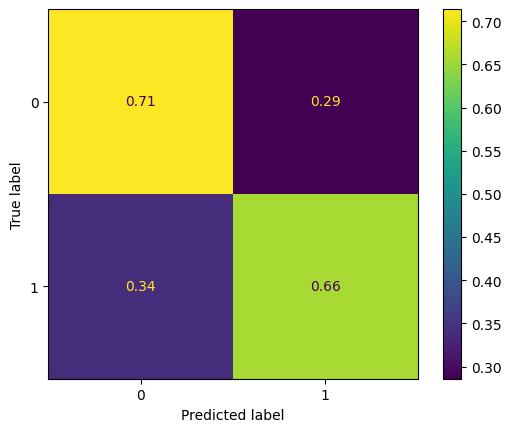

In [106]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cb_predictions = cb_cls.predict(gbt_features_test_X)
cm = confusion_matrix(gbt_features_test_y, cb_predictions, normalize='true')
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

### Train CatBoost model on full dataset

In [109]:
cb_cls_full = CatBoostClassifier(
    iterations=100,
    class_weights=[positive_classes_rate, 1 - positive_classes_rate],
    eval_metric=BalancedAccuracy(),
    objective=Logloss()
)

cb_pool = Pool(
    gbt_features.drop(columns=['user_uid', 'element_uid', 'label']), 
    gbt_features['label']
)

cb_cls_full.fit(cb_pool)

/home/user/conda/envs/hse/lib/python3.8/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Learning rate set to 0.5
0:	learn: 0.6631630	total: 1.01s	remaining: 1m 40s
1:	learn: 0.6677024	total: 2.05s	remaining: 1m 40s
2:	learn: 0.6703435	total: 3.03s	remaining: 1m 37s
3:	learn: 0.6708573	total: 3.94s	remaining: 1m 34s
4:	learn: 0.6714180	total: 4.89s	remaining: 1m 32s
5:	learn: 0.6720558	total: 5.89s	remaining: 1m 32s
6:	learn: 0.6726958	total: 6.78s	remaining: 1m 30s
7:	learn: 0.6730984	total: 7.59s	remaining: 1m 27s
8:	learn: 0.6733449	total: 8.54s	remaining: 1m 26s
9:	learn: 0.6737587	total: 9.47s	remaining: 1m 25s
10:	learn: 0.6739151	total: 10.4s	remaining: 1m 24s
11:	learn: 0.6739326	total: 11.3s	remaining: 1m 22s
12:	learn: 0.6740855	total: 12.1s	remaining: 1m 21s
13:	learn: 0.6746664	total: 13s	remaining: 1m 19s
14:	learn: 0.6748509	total: 13.8s	remaining: 1m 18s
15:	learn: 0.6751023	total: 14.6s	remaining: 1m 16s
16:	learn: 0.6755223	total: 15.6s	remaining: 1m 16s
17:	learn: 0.6757670	total: 16.5s	remaining: 1m 15s
18:	learn: 0.6761128	total: 17.5s	remaining: 1m 14s

In [110]:
cb_cls_full.save_model('data/catboost_full.cbm')